In [23]:
#подключим нужные библиотеки и читаем данные


import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

import hashlib
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
# from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from keras.model_selection import train_test_split
from tensorflow import keras
from scipy.ndimage import rotate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
import re
from finta import TA
import tensorflow as tf
import random 

import warnings
warnings.simplefilter(action='ignore', category=Warning)
pd.reset_option('all')

In [24]:
data = pandas.read_csv("F.csv")
candlesNNSee=40
candlesItPredict=1
daysInSingleLable=1
makeLabelsCountEqual=True

In [25]:
columnsToDelete = [0, 6]
data = data.drop(data.columns[columnsToDelete], axis=1)
data = data.reset_index()  # добавим колонку с индексами
data[:5]

,index,Low,Open,Volume,High,Close
0,0,2.149165,0.000000,1091238,2.173495,2.153220
1,1,2.141055,2.153220,1174468,2.173495,2.149165
2,2,2.141055,2.149165,5209582,2.169440,2.149165
3,3,2.116725,2.149165,1424158,2.157275,2.124835
4,4,2.112670,2.124835,675088,2.137000,2.112670


In [26]:

def Organize_ohlcv(data):
    cols = list(data.columns)
    index, Low, Open, Volume, High, Close = cols.index('index'), cols.index('Low'), cols.index('Open'), cols.index(
        'Volume'), cols.index('High'), cols.index('Close')
    cols[index], cols[Low], cols[Open], cols[Volume], cols[High], cols[Close] = cols[index], cols[Open], cols[High], \
                                                                                cols[Low], cols[Close], cols[Volume]
    data = data[cols]
    return data

data = Organize_ohlcv(data)
data.columns = ['index', 'open', 'high', 'low', 'close', 'volume']  # rename
data[:3]

,index,open,high,low,close,volume
0,0,0.000000,2.173495,2.149165,2.153220,1091238
1,1,2.153220,2.173495,2.141055,2.149165,1174468
2,2,2.149165,2.169440,2.141055,2.149165,5209582


<AxesSubplot:>

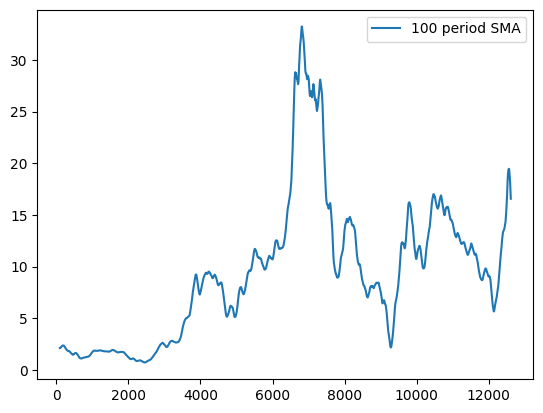

In [27]:

SMAb = TA.SMA(data, 100)  # Simple Moving Average
DEMAb = TA.DEMA(data)  # Double Exponential Moving Average
RSIb = TA.RSI(data)  # Relative Strenght Index  не понятно, найдет ли нейросеть на нём паттерны вообще
TRIMAb = TA.TRIMA(data)  # Triangular Moving Average   !!!!
KAMAb = TA.KAMA(data)  # Kaufman's Adaptive Moving Average '!!!
ATRb = TA.ATR(data)  # Average True Range


SMAb = SMAb.to_frame()
DEMAb = DEMAb.to_frame()
RSIb = RSIb.to_frame()
TRIMAb = TRIMAb.to_frame()
KAMAb = KAMAb.to_frame()
ATRb = ATRb.to_frame()

SMAb.plot()

In [28]:


# print(data.isnull().sum())

# сделаем цены в процентах от предыдущего дня, а не просто значения
def percent(thisNum, fromBase):
    if fromBase <= 0.1:
        fromBase = thisNum / 10
    if thisNum <= 0.1:
        thisNum = fromBase / 10
    try:
        return (100 / (fromBase / thisNum)) - 100
    except:
        if fromBase <= 0.1:
            fromBase = thisNum / 10
        if thisNum <= 0.1:
            thisNum = fromBase / 10
        return (100 / (fromBase / thisNum)) - 100

def makePercented(data):
    dt = data.copy()
    columns = range(len(list(data)))
    for i in columns:
        if i == 0:
            continue
        for index, row in data.iterrows():
            if index == 0:
                continue
            N = percent(data.iloc[index, i], data.iloc[index - 1, i])
            dt.iloc[index, i] = N
    return dt

data = makePercented(data)
data[:4]


,index,open,high,low,close,volume
0,0,0.000000,2.173495,2.149165,2.153220,1.091238e+06
1,1,900.000000,0.000000,-0.377347,-0.188324,7.627117e+00
2,2,-0.188324,-0.186567,0.000000,0.000000,3.435695e+02
3,3,0.000000,-0.560747,-1.136362,-1.132063,-7.266272e+01


In [29]:

# добавим колонку с категориями, которые мы будем в итоге угадывать (но тут они пока свои на строку)
def Average(array):
    summed = 0
    for each in array:
        summed += each
    return summed / len(array)

def averageLine(data, columns, NLinesToAverage):
    if NLinesToAverage == 1:
        NLinesToAverage = 1
    data['Averaged'] = 0
    for index, row in data.iterrows():
        if index + NLinesToAverage > len(data):
            NLinesToAverage = len(data) - index
        arrayToCount = []
        for lines in range(NLinesToAverage):
            for elemntInLine in columns:
                arrayToCount.append(data.iloc[index + lines, elemntInLine])
        data["Averaged"][index] = Average(arrayToCount)
    return data

def CatFour(Num, catMin, catMax):  # четыре категории - сильно рост, слабо рост. Сильное падение, слабое падение
    if 0 < Num < catMax:
        return 2
    elif Num > catMax:
        return 3
    elif 0 >= Num > catMin:
        return 1
    elif Num < catMin:
        return 0

def addCategorical(data, column, borderPercent):
    borderPercent = borderPercent  # 1% и -1% будут границей, больше и меньше которой интересные категории. а внутри неинтересные - мало движения потому-что
    data['catLabels'] = 0
    for index, row in data.iterrows():
        data["catLabels"][index] = CatFour(data.iloc[index, column], -borderPercent, borderPercent)
    return data

data = averageLine(data, [1, 2, 3, 4], daysInSingleLable)
columnindex = list(data.columns).index("Averaged")# индекс колонки по которой будут считаться категории. Если не добавлять дополнительные параметры, то 6
borderPercent = 1
data = addCategorical(data, columnindex, borderPercent)

<AxesSubplot:>

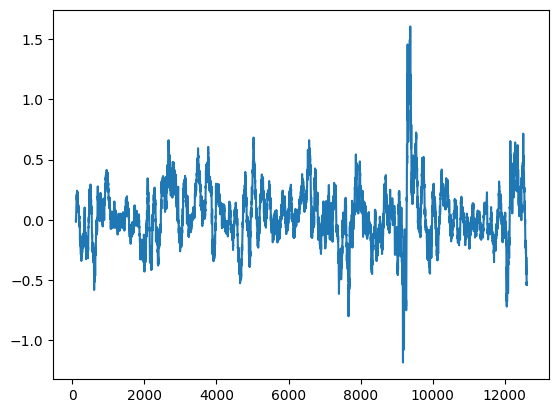

In [30]:

# воткнем значения технического анализа
# те, которые b - до процентов
# те, котрые без b - посчитаны уже по процентам


SMAb = makePercented(SMAb)
DEMAb = makePercented(DEMAb)
RSIb = makePercented(RSIb)
TRIMAb = makePercented(TRIMAb)
KAMAb = makePercented(KAMAb)
ATRb = makePercented(ATRb)


# тоже самое, только теперь расчет от процентов
SMA = TA.SMA(data, 100)  # Simple Moving Average
OBV = TA.OBV(data)  # On Balance Volume
DEMA = TA.DEMA(data)  # Double Exponential Moving Average
TRIMA = TA.TRIMA(data)  # Triangular Moving Average   !!!!
KAMA = TA.KAMA(data)  # Kaufman's Adaptive Moving Average '!!!


# добавляем индикаторы к данным
data['SMAb'] = SMAb
data['SMA'] = SMA
data['OBV'] = OBV
data['DEMAb'] = DEMAb
data['DEMA'] = DEMA
data['RSIb'] = RSIb
data['TRIMAb'] = TRIMAb
data['TRIMA'] = TRIMA
data['KAMAb'] = KAMAb
data['KAMA'] = KAMA
data['ATRb'] = ATRb
# data['TSIb'] = TSIb
# data['TSI'] = TSI
# data[''] = 
SMA.plot()

In [31]:
data = data.interpolate()# интерполируем значения, чтоб избежать NaN значений от функций тех.Анализа
# но вообще OBV наверное стоит убрать, раз он делает нан

data = data[100:]  # убираем первую сотню всего потому, что SMA не вписывает туда значения
columnsToDelete = [0]  # удалим индекс
data = data.drop(data.columns[columnsToDelete], axis=1)

print("Количество NAN значений в данных ", sum(data.isnull().sum()))
print(data.isnull().sum())


Количество NAN значений в данных  0
open         0
high         0
low          0
close        0
volume       0
Averaged     0
catLabels    0
SMAb         0
SMA          0
OBV          0
DEMAb        0
DEMA         0
RSIb         0
TRIMAb       0
TRIMA        0
KAMAb        0
KAMA         0
ATRb         0
dtype: int64


In [32]:
data[:4]

,open,high,low,close,volume,Averaged,catLabels,SMAb,SMA,OBV,DEMAb,DEMA,RSIb,TRIMAb,TRIMA,KAMAb,KAMA,ATRb
100,1.568614,0.578034,1.568614,0.193095,39.622636,0.977089,2,2.112061,-0.017744,354.735228,2.086316,0.337783,48.682323,2.116149,-0.008126,2.091396,-0.071218,0.025199
101,0.386145,0.957853,0.386145,1.541424,-51.719909,0.817892,2,2.111940,-0.000447,303.015318,2.103172,0.806034,55.964139,2.115986,-0.003549,2.091683,-0.051966,0.026068
102,1.153845,-0.189753,0.384615,-0.569259,-11.450408,0.194862,2,2.111696,-0.006139,314.465727,2.110933,0.375284,52.930957,2.115698,-0.009405,2.092059,-0.055632,0.026068
103,-0.380228,0.000000,0.191571,0.190839,26.436832,0.000546,2,2.111737,0.007090,340.902559,2.117916,0.335458,53.829252,2.115223,-0.018150,2.092388,-0.052490,0.024041


In [33]:
# нормализуем фичи
def makeItNormed(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    df_norm = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns)
    return df_norm

# def makeItNormed(data):
#     x = data.values  # returns a numpy array
#     min_max_scaler = preprocessing.MinMaxScaler()
#     x_scaled = min_max_scaler.fit_transform(x)
#     return pd.DataFrame(x_scaled)

dataNormed = makeItNormed(data)

print("len(data)", len(data),"len(dataNormed)", len(dataNormed))

len(data) 12513 len(dataNormed) 12513


In [34]:
# функция, которая отдает все варианты лэйблов в конкретной колонке
def countAllTypes(data, name):
    spisok = []
    for index, row in data.iterrows():
        labelType = row[name]
        if labelType in spisok:
            pass
        else:
            spisok.append(labelType)
    return spisok

labelCount = len(countAllTypes(data, "catLabels"))
allLabels = countAllTypes(data, "catLabels")

print("всего лэйблов ", labelCount, "все варианты лэйблов ", allLabels)

print(type(data),type(dataNormed))


всего лэйблов  4 все варианты лэйблов  [2.0, 3.0, 1.0, 0.0]
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [35]:
dataNormed[:2]

,open,high,low,close,volume,Averaged,catLabels,SMAb,SMA,OBV,DEMAb,DEMA,RSIb,TRIMAb,TRIMA,KAMAb,KAMA,ATRb
0,0.418277,0.535446,0.406769,0.462105,0.042781,0.380969,0.666667,0.043001,0.418055,0.013606,0.040633,0.466172,0.471089,0.041911,0.507743,0.041404,0.490967,0.006885
1,0.402514,0.539893,0.390547,0.486837,0.013543,0.377815,0.666667,0.042997,0.424260,0.012181,0.041109,0.479623,0.566316,0.041906,0.508412,0.041413,0.494145,0.007407


<AxesSubplot:>

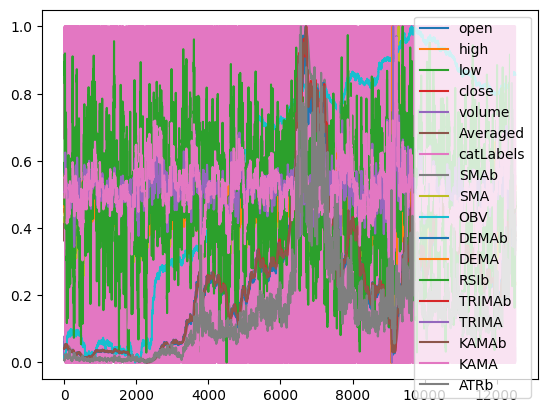

In [36]:
dataNormed.plot()

In [37]:
def makeLabels(data, candlesNNSee, candlesItPredict, labelsColumn):
    # следующие две строки нужны потому, что иначе он делает багу и стартует не от-туда, а прям по индексам.
    data = data.reset_index()
    data = data.drop(data.columns[[0]], axis=1) # можно не делать. Один черт лэйблы получаем
    data = data[labelsColumn]
    temp = data[candlesNNSee:candlesNNSee + candlesItPredict]
    temp.to_numpy()
    ArrImOur = np.array([temp])
    ArrImOur = ArrImOur.astype(np.int8)
    for index, row in data.iteritems():
        if index <= candlesNNSee:
            continue
        if index + candlesItPredict > len(data):
            break
        temp = data[index:index + candlesItPredict]
        temp.to_numpy()
        ArrImOur = np.vstack((ArrImOur, [temp]))
        ArrImOur = ArrImOur.astype(np.int8)
    return ArrImOur

labels = makeLabels(data, candlesNNSee, candlesItPredict, 'catLabels')

In [38]:
def makeFeatures(data, candlesNNSee, candlesItPredict):
    # следующие две строки нужны потому, что иначе он делает багу и стартует не от-туда, а прям по индексам.
    data = data.reset_index()
    data = data.drop(data.columns[[0]], axis=1)
    # поскольку мы показываем итоговой нейросети сразу картинку - множество дней, то тут мы создаем np массив и заполняем его первым элементом нужного размера
    temp = data[0:candlesNNSee]
    temp.to_numpy()
    ArrImOur = np.array([temp])
    data = data[:len(data) - candlesItPredict + 1]
    # дальше мы заполняем массивами после первого, но первый пропускаем, поэтому тут if
    for index, row in data.iterrows():
        if index <= candlesNNSee:
            continue
        temp = data[index - candlesNNSee:index]  # отрезок от старта до сейчас.
        temp.to_numpy()
        ArrImOur = np.vstack((ArrImOur, [temp]))  # добавили картинку в конец массива
    return ArrImOur

features = makeFeatures(dataNormed, candlesNNSee, candlesItPredict)



In [39]:

assert not np.any(np.isnan(labels))
assert not np.any(np.isnan(features))    

In [40]:
# выведем различные показатели нашего датасета.
print("размерность фич",features.shape)
print("размерность одного элемента фичи",features[0].shape)
print("тип данных фич ",type(features))
print("тип данных одной фичи",type(features[0]))
print("тип данных одного пискселя ", type(features[0][0][0]))
print("|")
print("размерность лэйблов", labels.shape)
print("класс лэйбла нулевого элемента", labels[0])
print("тип данных лэйблов ", type(labels))
print("тип данных нулевого лэйбла ", type(labels[0]))
print("тип данных лэйбла ", type(labels[0][0]))
print("Если нейросеть будет тыкать только в самый частый лэйбл, то accuracy будет ",100/(sum(pd.DataFrame(labels)[0].value_counts())/max(pd.DataFrame(labels)[0].value_counts())))
print("количество элементовкаждого класса \n", pd.DataFrame(labels)[0].value_counts())

размерность фич (12473, 40, 18)
размерность одного элемента фичи (40, 18)
тип данных фич  <class 'numpy.ndarray'>
тип данных одной фичи <class 'numpy.ndarray'>
тип данных одного пискселя  <class 'numpy.float64'>
|
размерность лэйблов (12473, 1)
класс лэйбла нулевого элемента [2]
тип данных лэйблов  <class 'numpy.ndarray'>
тип данных нулевого лэйбла  <class 'numpy.ndarray'>
тип данных лэйбла  <class 'numpy.int8'>
Если нейросеть будет тыкать только в самый частый лэйбл, то accuracy будет  27.667762366712097
количество элементовкаждого класса 
 2    3451
1    3415
3    2862
0    2745
Name: 0, dtype: int64


In [41]:
def makeItDF(data):
    typ = str(type(data))
    if typ == "<class 'numpy.ndarray'>":
        data = pd.DataFrame(data)
    if typ == "<class 'pandas.core.frame.DataFrame'>":
        pass
    return data

def makeItNP(data):
    typ = str(type(data))
    if typ == "<class 'numpy.ndarray'>":
        pass
    if typ == "<class 'pandas.core.frame.DataFrame'>":
        data.to_numpy()
    return data

def giveMeRawsWhereTheeseTypes(data, labelTypes, itsColumn):
    data = makeItDF(data)
    listOfIndexes = []
    for index, row in data.iterrows():
        if row[0] in labelTypes:
            listOfIndexes.append(int(index))
    return listOfIndexes

def dropTheeseIndexes(data, listOfIndexes):
    typ = str(type(data))
    if typ == "<class 'numpy.ndarray'>":
        data = np.delete(data, listOfIndexes, 0)
    if typ == "<class 'pandas.core.frame.DataFrame'>":
        data = data.drop(index=listOfIndexes)
    data = makeItNP(data)
    return data

def EqualizeLabels(labels,
                   features):  # выравниваем датасет чтоб количество лэйблов каждого типа было равным. сейчас работает только если 1 лэйбл
    targetLabeCount = int(min(pd.DataFrame(labels)[0].value_counts()))
    counter = 0  # каунтер тут нужен для того, чтоб указывать на категории (0,1,2,3)
    for each in pd.DataFrame(labels).value_counts():
        if each >= targetLabeCount:
            listOfIndexes = giveMeRawsWhereTheeseTypes(labels, [counter], 0)
            features = dropTheeseIndexes(features, listOfIndexes[targetLabeCount:])
            labels = dropTheeseIndexes(labels, listOfIndexes[targetLabeCount:])
        counter += 1
    # print("количество элементов каждого класса \n", pd.DataFrame(labels)[0].value_counts())
    return labels, features

if makeLabelsCountEqual == True:
    labels, features = EqualizeLabels(labels, features)


In [42]:
import sys
print("features:",round(sys.getsizeof(features)/1024/1024,2), "mb")

features: 60.32 mb


спрашиваем с нейросети категорию:  [0]  а показываем:


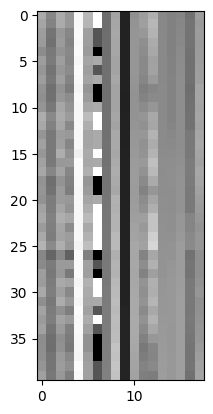

In [43]:
which = -1
plt.imshow(features[which],cmap = plt.cm.binary)
print("спрашиваем с нейросети категорию: ",labels[which], " а показываем:")